# **Classificazione dei prodotti di Scattering Elettrone-Protone**

Confronto tra diversi modelli di *apprendimento supervisionato* per la *classificazione* di particelle prodotte durante uno scattering inelastico elettrone-protone basato sulla risposta di sei diversi rilevatori. L'obiettivo è quello di identificare le particelle e valutare il migliore modello tra i seguenti:

- **Decision Tree**
- **Random Forest**
- **Multilayer Perceptron**

I dati utilizzati sono il prodotto della risposta di sei diversi rilevatori mediante la piattaforma di simulazione *[GEANT4](https://geant4.web.cern.ch/)*. Il DataSet è reperibile su *[Kaggle](https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses)*.

## **Analisi Esplorativa dei dati**

Importo i moduli e le librerie di interesse, utili per l'analisi del dataset.

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Carico il dataset in locale.

In [168]:
df = pd.read_csv("..\GEANT4_Simulation.csv")
df.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


Per una maggiore leggibilità rinomino la colonna **id** e **nphe**.

Inoltre sostituisco il *codice* associato a ciascuna particella con il suo **nome** rimappando i valori. Per tale operazione uso il metodo [`dict.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html).

In [169]:
# Dizionario contente l'associazione chiave valore id:nome

dictParticelle = { -11 : 'positrone',
                  211 : 'pione',
                  321 : 'kaone',
                  2212 : 'protone'}

**Composizione DataSet**

|    Features    |              Significato              | Unità di Misura |
| :-------------: | :------------------------------------: | :--------------: |
|  **id**  |            Nome Particella            |    $NoDim$    |
|   **p**   |           Quantità di moto           |    $GeV/c$    |
| **theta** |          Angolo di Scattering          |     $rad$     |
| **beta** | Rapporto tra la velocità$v$ e $c$ |    $NoDim$    |
| **nphe** |        Numero di fotoelettroni        |    $NoDim$    |
|  **ein**  |          Energia in ingresso          |     $GeV$     |
| **eout** |           Energia in uscita           |     $GeV$     |


**Valore Particelle**
|        id        | Particella |              Simbolo              |   Massa (MeV)
| :--------------: | :--------: | :-------------------------------: | :-------------:
| **(-11)** | Positroni |              $e^+$              | $0.51$
| **(211)** |   Pioni   | $\pi \quad (\pi^0,\pi^+,\pi^-)$ | $133$
| **(321)** |   Kaoni   |     $K \quad (K^0,K^+,K^-)$     | $495$
| **(2212)** |  Protoni  |               $p$              | $940$

In [170]:
# Rinomino le colonne 'id' e 'nphe'
df.rename(columns={'id' : 'particella'}, inplace=True)
df.rename(columns={'nphe' : 'elettroni'}, inplace=True)
# Rimappo i valori della colonna 'particella'
df['particella'] = df['particella'].map(dictParticelle)

In [171]:
df.head(100)

,particella,p,theta,beta,elettroni,ein,eout
0,pione,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,pione,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,protone,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,pione,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,protone,2.123290,0.337332,0.908652,0,0.034379,0.049256
...,...,...,...,...,...,...,...
95,protone,1.360950,0.147539,0.824000,0,0.000000,0.000000
96,pione,1.346610,0.241262,0.984269,0,0.251499,0.095903
97,protone,0.993210,0.755494,0.733585,0,0.000000,0.000000
98,pione,0.596323,0.722834,0.971532,0,0.000000,0.000000


Controllo adesso se per qualche particella mancano delle feature e verifico la dimensionalità del dataframe. Per farlo uso [`pd.DataFrame.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html) e [`pd.DataFrame.sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html).

In [172]:
print(df.isnull().sum())
print("-"*20)
print(df.shape)

particella    0
p             0
theta         0
beta          0
elettroni     0
ein           0
eout          0
dtype: int64
--------------------
(5000000, 7)


Ci sono cinque milioni di particelle, ciascuna con sette features e nessun dato è mancante.

Osservo ora in che proporzione stanno i prodotti tra di loro.

pione        56.13666
protone      38.91698
kaone         4.64942
positrone     0.29694
Name: particella, dtype: float64


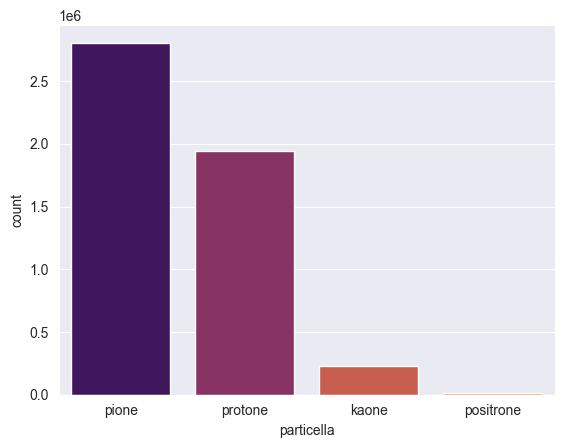

In [173]:
sns.set_style("darkgrid")
sns.countplot(x = df['particella'],
              palette='inferno')

print(df['particella'].value_counts(normalize = True) * 100)

Come si può vedere i **positroni** e **kaoni** sono rispettivamente solo un $4%$ circa e lo $0.3%$, ossia sono classi *sottorappresentate*. Pertanto è necessario effettuare un **resampling** del dataset in maniera tale da rendere tutte le classi equirappresentate e non avere un dataset sbilanciato.

In particolare andremo ad effettuare un **undersampling**, implementato Scikit Learn attraverso l'oggetto `RandomUnderSampler` offerto dalla libreria [`imbalanced Learn`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html).

In [174]:
# Mostro il numero di particelle per ciascuna classe 
sp = df['particella'].value_counts()
print(sp)

pione        2806833
protone      1945849
kaone         232471
positrone      14847
Name: particella, dtype: int64


In [175]:
from imblearn.under_sampling import RandomUnderSampler

In [176]:
# Resampling - undersampling
x = pd.DataFrame(df)
y = x['particella']

undersample = RandomUnderSampler(sampling_strategy='not minority')
df_us, _ = undersample.fit_resample(x, y)

kaone        14847
pione        14847
positrone    14847
protone      14847
Name: particella, dtype: int64


<AxesSubplot:xlabel='particella', ylabel='count'>

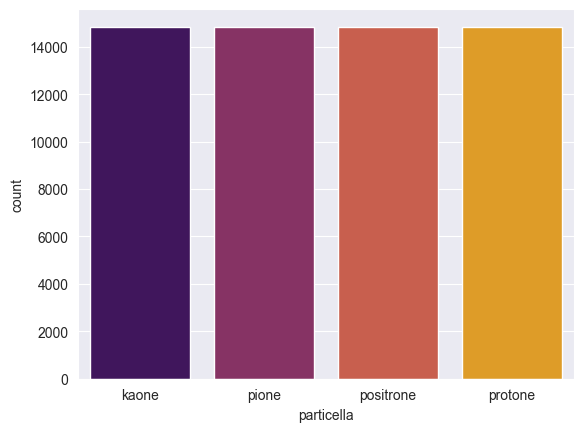

In [177]:
# Mostro il nuovo numero di particelle per ciascuna classe
print(df_us['particella'].value_counts())

sns.set_style("darkgrid")
sns.countplot(x = df_us['particella'],
              palette='inferno')

In [178]:
print("Numero di Particelle nel DataSet Iniziale: {}\n".format(df.shape[0]))
print("Numero di Particelle nel DataSet Finale: {}\n".format(df_us.shape[0]))
print("Il DataSet è stato ridotto del {:.2%}".format((df.shape[0]-df_us.shape[0])/df.shape[0]))

Numero di Particelle nel DataSet Iniziale: 5000000

Numero di Particelle nel DataSet Finale: 59388

Il DataSet è stato ridotto del 98.81%


Ora che il dataset è bilanciato, vedo se c'è qualche correlazione tra le feature mediante una matrice di correlazione.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

<AxesSubplot:>

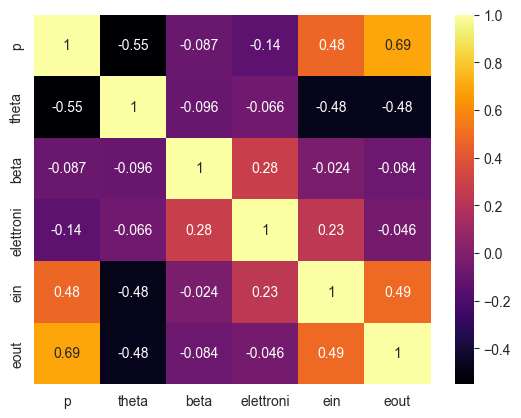

In [179]:
sns.set_style("darkgrid")
sns.heatmap(df_us.corr(method="spearman"), annot=True, cmap="inferno")

L'unica correlazione significativa che posso individuare è tra la *quantità di moto* e l'*energia in uscita*: fisicamente ciò è coerente, poichè particelle le particelle più veloci sono anche le più energetiche.

Osservando il dataset ipotizzo che il rilevatore circa gli elettroni è stato inneficente (segna spesso 0). Verifico questa ipotosi e eventualmente elimino la colonna prima dell'addestramento dei modelli.

In [93]:
df_us.head()

,particella,p,theta,beta,elettroni,ein,eout
0,kaone,0.851759,0.330012,0.878211,0,0.193042,0.046647
1,kaone,1.780880,0.182083,0.959495,0,0.026734,0.176837
2,kaone,0.845350,0.562815,0.867583,0,0.044221,0.106111
3,kaone,2.304880,0.212053,0.978515,0,0.024811,0.059922
4,kaone,2.092470,0.388337,0.989550,0,0.031815,0.030671


In [180]:
flop = df_us['elettroni'].value_counts(normalize = True)
print('Il rilevatore manca il segnale il {volte:.2%} delle volte'.format(volte=flop[0]))

Il rilevatore manca il segnale il 85.65% delle volte


Pertanto posso eliminare la feature **elettroni**, in quanto non significativa.

In [181]:
df_us.drop(columns = ['elettroni'], inplace=True)
df_us.head()

,particella,p,theta,beta,ein,eout
0,kaone,1.49660,0.335150,0.955864,0.124010,0.160723
1,kaone,1.84283,0.438900,0.986725,0.041886,0.049210
2,kaone,1.64340,0.338203,0.971822,0.031083,0.055711
3,kaone,1.56390,0.342095,0.959970,0.038682,0.055436
4,kaone,2.20005,0.213621,0.971147,0.035752,0.050904


Così perchè non so che fare vedo come cambia la velocità con l'impulso, ovviamente mi aspetto che tendano tutti ad 1 forse... 

From the figure above the different particle types can be seen. This is a so-called Time-Of-Flight plot, where on the y-axis is the relativistic velocity beta = v/c, where v is the velocity and c the speed of light and on the x-axis is the momentum of the particle. Here Monte Carlo information is used to visualize the different particle behaviour due to the different particle masses. Pions which are the lightest hadrons get closer to the limiting speed of light, i.e. beta approximately unity, where the heavier kaons and protons still have smaller velocities. Particles can be in particular separated by their different mass.

commento preso da: 
https://www.kaggle.com/code/mkkoehler/particle-id-using-a-couple-of-ml-algorithms

[Text(0.5, 0, 'quantità di moto p'),
 Text(0, 0.5, 'velocità relativistica b'),
 Text(0.5, 1.0, 'b vs p')]

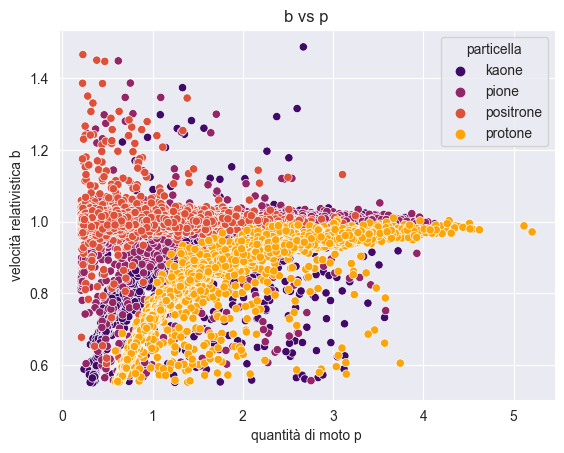

In [136]:
sns.set_style("darkgrid")
sns.scatterplot(
    data=df_us,
    x='p',
    y='beta',
    hue='particella',
    palette = 'inferno'
    ).set(xlabel='quantità di moto p', ylabel='velocità relativistica b', title = "b vs p")

Mi creo una funzione che mi faccia vedere visivamente come le particelle si distribuiscono rispetto le loro feature
e uso uno "kernel density estimition plot KDE" che è più facile da interpretare. "Stima kernel di densità" (https://it.wikipedia.org/wiki/Stima_kernel_di_densit%C3%A0). Si può usare anche displot e come parametro kind = "kde"

In [137]:
sns.set_style("darkgrid")

def distribuzione(colonna, target = 'particella'):
    for tag in df_us[target].unique(): #Plotto un grafico per ogni tipo di particella
        sns.kdeplot(data=df_us[df_us[target] == tag][colonna], label = tag, palette = 'inferno')
    
    sns.kdeplot(data=df_us[colonna],label = "Tutte", fill = True, palette = 'inferno')
    plt.legend()

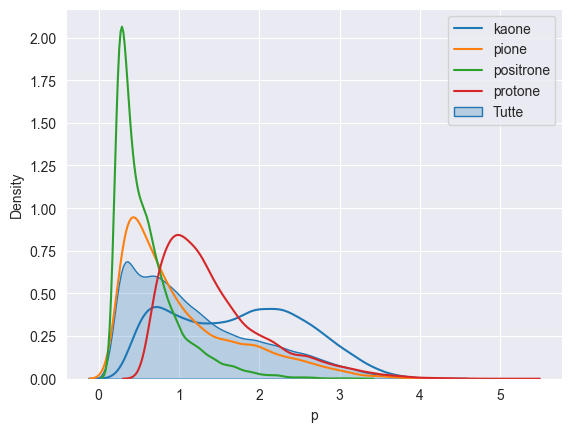

In [138]:
distribuzione('p')

## **Seconda Parte: Scelta del modello e Addestramento**

In [99]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

## **Classificazione Supervisionata: sto selezionando io le classi**
Random forests is a set of multiple decision trees.
Deep decision trees may suffer from overfitting, but random forests prevents overfitting by creating trees on random subsets.
Decision trees are computationally faster.
Random forests is difficult to interpret, while a decision tree is easily interpretable and can be converted to rules.

In [139]:
x = df_us.drop(columns = ['particella']) # Le features ovviamente sono tutte quelle tranne il nome della particella
y = df_us['particella'] #label

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 3, train_size = 0.8)

## **Albero Decisionale**

In [140]:
dt_class = DecisionTreeClassifier()
dt_class.fit(x_train, y_train)
y_pred_dt = dt_class.predict(x_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print('Accuratezza DecisionTree:\n{:.2%}'.format(dt_accuracy))


Accuratezza DecisionTree:
90.14%


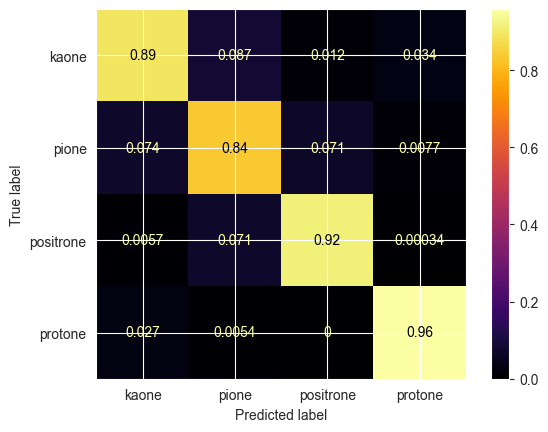

In [141]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap='inferno', normalize = 'pred')

## **Random Forest**

In [103]:
rf_class = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf_class.fit(x_train, y_train)
y_pred_rf = rf_class.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print('Accuratezza RandomForest:\n{:.2%}'.format(rf_accuracy))

Accuratezza RandomForest:
93.37%


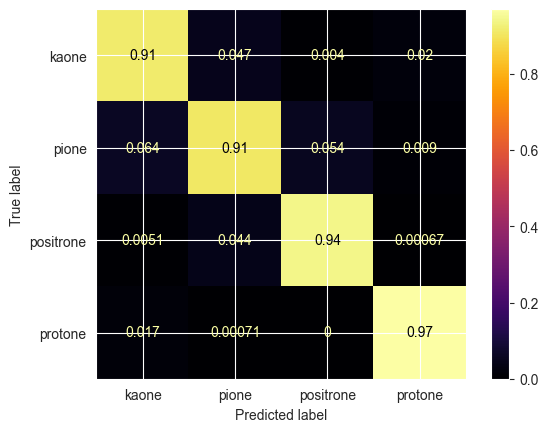

In [104]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='inferno', normalize = 'pred')

Valuto l'importanza delle features "feature_importances_"

In [105]:
importanza = pd.DataFrame(data={'Feature': x_train.columns,
                                'Importanza': rf_class.feature_importances_})
importanza.head()

,Feature,Importanza
0,p,0.312387
1,theta,0.053811
2,beta,0.468666
3,ein,0.099869
4,eout,0.065267


[Text(0.5, 1.0, 'Random Forest - Importanza delle Features')]

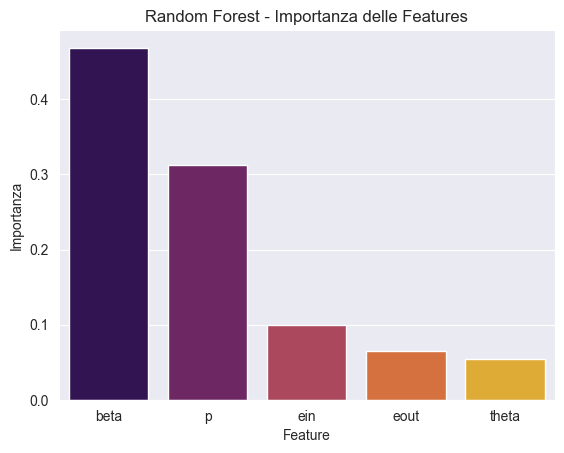

In [106]:
sns.barplot(data = importanza,
            x=importanza['Feature'],
            y=importanza['Importanza'], 
            order = importanza.sort_values('Importanza',ascending = False).Feature, 
            palette = 'inferno').set(title = "Random Forest - Importanza delle Features")

Come si può vedere è la qdm insieme alla velocità relativistica come features ad essere importanti per l'addestramento del modello e la successiva predizione. Si poteva aspettare dal plot delle velocità, attaverso il quale è possibile distinguere l'andamento delle particelle.

## **Multilayer Perceptron**

Cerco di ottimizzare gli iperparametri passati al MLPClassifier:
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [107]:
griglia_parametri = [
    
        {
            'activation' : ['logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [(1,),(5,),(10,),(100,)]
        }
       ]

# I migliori parametri per il MLPClassifier sono:
# {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [108]:
mlp_class = MLPClassifier(max_iter=10)
mlp_upgrade = GridSearchCV(mlp_class, griglia_parametri, n_jobs=-1)
mlp_upgrade.fit(x_train, y_train)

print("I migliori parametri per il MLPClassifier sono:\n{}\n".format(mlp_upgrade.best_params_))

y_pred_mlp = mlp_upgrade.predict(x_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)

print('Accuratezza RandomForest:\n{:.2%}'.format(mlp_accuracy))

I migliori parametri per il MLPClassifier sono:
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

Accuratezza RandomForest:
86.81%


c:\Users\Marco Cecca\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


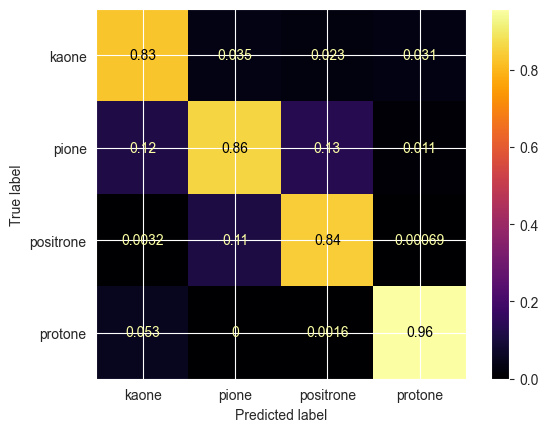

In [143]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, cmap='inferno', normalize = 'pred')

## **Confronto dell'efficienza dei modelli**

In [144]:
accuracy_vector = np.array([dt_accuracy, rf_accuracy, mlp_accuracy])
classificatori = np.array(['Decision Tree', 'Random Forest', 'Multilayer Perceptron'])

df = pd.DataFrame({"Classifier": classificatori,
                   "Accuracy": accuracy_vector})

df

,Classifier,Accuracy
0,Decision Tree,0.901414
1,Random Forest,0.933743
2,Multilayer Perceptron,0.868075


[Text(0.5, 1.0, 'Confronto Classificatori - Accuratezza'), (0.85, 0.95)]

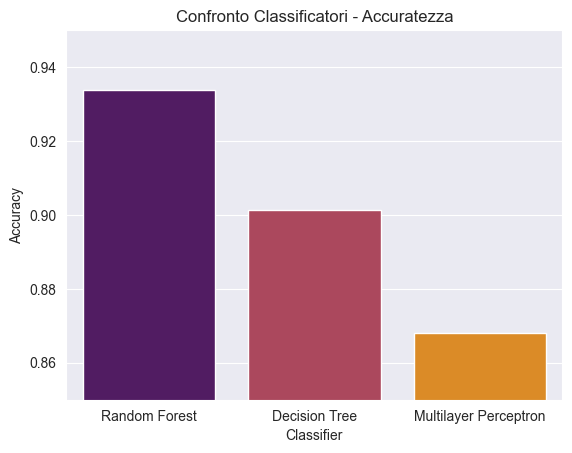

In [145]:
sns.barplot(data = df, x=df['Classifier'], y=df['Accuracy'], 
            order = df.sort_values('Accuracy',ascending = False).Classifier, 
            palette = 'inferno').set(title = "Confronto Classificatori - Accuratezza",
                                     ylim=(0.85,0.95))